In [1]:
import torch
import clip
from PIL import Image, ImageFilter, ImageEnhance

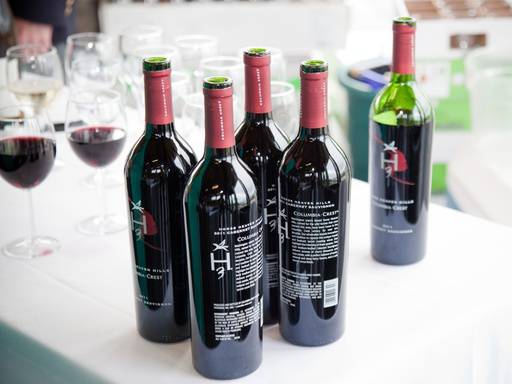

In [2]:
original = Image.open("/Users/kuang-yujeng/Documents/dataset/koniq-10k/10464940425.jpg")
original

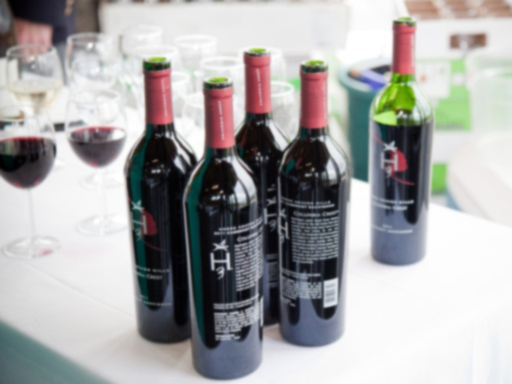

In [3]:
blur1 = original.filter(ImageFilter.GaussianBlur(1))
blur1

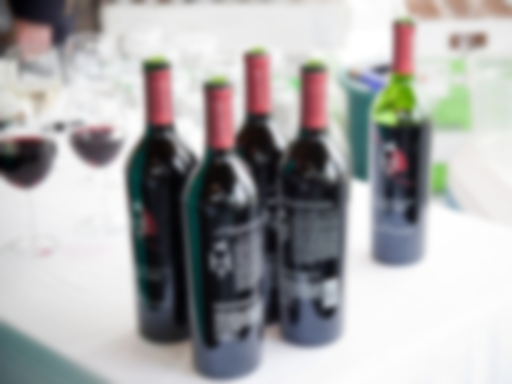

In [4]:
blur3 = original.filter(ImageFilter.GaussianBlur(3))
blur3

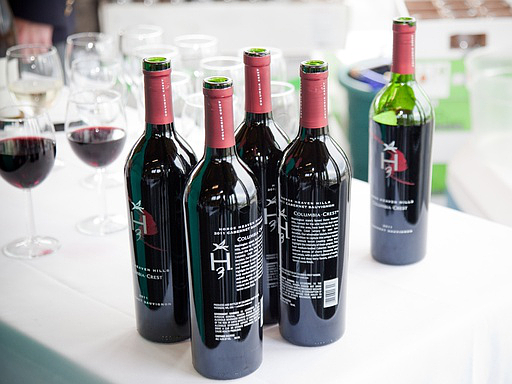

In [5]:
enhance = ImageEnhance.Sharpness(original)
sharp = enhance.enhance(2.0)
sharp

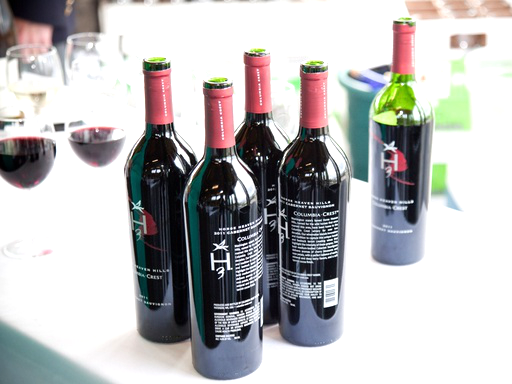

In [6]:
enhance = ImageEnhance.Brightness(original)
brighten = enhance.enhance(1.2)
brighten

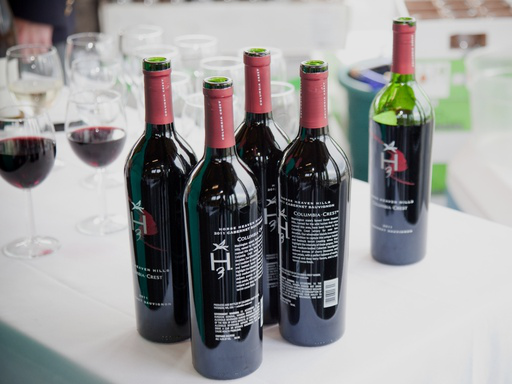

In [7]:
enhance = ImageEnhance.Brightness(original)
darken = enhance.enhance(0.9)
darken

In [8]:
model, preprocess = clip.load("RN50", device='cpu')

In [9]:
text = clip.tokenize([
                      "Good photo.", "Bad photo.",
                      "Good bright photo.", "Bad dark photo.",
                      "Good contrast photo.", "Bad low contrast photo.",
                      "Good sharp edge.", "Bad blurry edge.",
                      "Sharp image.", "Blurry image.",
                      "Good accurate color white balance.", "Bad color white balance cast.",
                      "Good natural face color.", "Bad face color cast.",
])

In [10]:
image = torch.cat((preprocess(blur3).unsqueeze(0), 
                   preprocess(blur1).unsqueeze(0), 
                   preprocess(original).unsqueeze(0),
                   preprocess(sharp).unsqueeze(0),
                   preprocess(brighten).unsqueeze(0),
                   preprocess(darken).unsqueeze(0),
                  ), 0)

In [11]:
print("Good, Bright, Contrast, Edge, Sharp")
with torch.no_grad():
    text_features = model.encode_text(text)
    image_features = model.encode_image(image)
    text_vector = text_features[::2] - text_features[1::2] # (6, 1024)
    
    v_text = text_vector[:1]
    U = text_vector[1:]
    v2_text = v_text @ v_text.T
    Uv_text = U @ v_text.T
    mag_text = (Uv_text / v2_text)
    
    print(mag_text)
    
    img_vector = image_features.unsqueeze(1) - text_features[1::2].unsqueeze(0)
    text_vector2 = (torch.norm(text_vector, dim=1)**2)[None,...,None]
    
    Uv_img = (img_vector * text_vector).sum(2, keepdim=True)
    mag_img = (Uv_img / text_vector2)
    print(mag_img)
    
    print(mag_text.size(), mag_img.size())
    
    scores = torch.sum(mag_text[None] * mag_img[:,1:], 1) + 0.5 * mag_img[:,0]
    print(scores.size())
    print(scores)
    

Good, Bright, Contrast, Edge, Sharp
tensor([[0.7913],
        [0.6230],
        [0.5287],
        [0.8035],
        [0.2676],
        [0.2863]])
tensor([[[ 0.2505],
         [ 0.1982],
         [ 0.7244],
         [ 0.7308],
         [ 0.0803],
         [-0.0440],
         [ 0.2668]],

        [[ 0.2594],
         [ 0.2054],
         [ 0.7348],
         [ 0.7376],
         [ 0.0880],
         [-0.0460],
         [ 0.2671]],

        [[ 0.2703],
         [ 0.2130],
         [ 0.7425],
         [ 0.7436],
         [ 0.0991],
         [-0.0475],
         [ 0.2700]],

        [[ 0.2738],
         [ 0.2148],
         [ 0.7462],
         [ 0.7476],
         [ 0.1046],
         [-0.0462],
         [ 0.2725]],

        [[ 0.2580],
         [ 0.2092],
         [ 0.7314],
         [ 0.7417],
         [ 0.0948],
         [-0.0483],
         [ 0.2697]],

        [[ 0.2685],
         [ 0.2094],
         [ 0.7435],
         [ 0.7430],
         [ 0.0985],
         [-0.0460],
         [ 0.2687]]])
tor

In [12]:
mag_text

tensor([[0.7913],
        [0.6230],
        [0.5287],
        [0.8035],
        [0.2676],
        [0.2863]])